In [ ]:
'''
** Major 학회

CV       : CVPR, ECCV, ICCV      # 검색: cifar 10 "cvpr" github  
DL/ML    : ICML, ICLR, NIPS      # paperswithcode.com :논문과 코드를 같이 볼수 있고, Task별로 찾아들어 갈 수 있다.
Journal  : TIP, TOG

SOTA(state-of-the-art) 예술의경지...
SOTA를 찍어야 학회 등재 가능 / 1등 찍어야 한다.
6개 학회에서 굉장히 speedy하게 새로운 논문들이 쏟아져나옴 
학회에서는 무료로 누구나 논문을 볼 수 있다. -> arxiv.org
'''

# Deep Nerual Network Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt

random_seed = 4332
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

use_cuda = True
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
# %matplotlib inline
# %matplotlib qt

 
## Classification Dataset

다음과 같은 classification dataset을 만든다.

* Generate random (x, y) using `torch.randn` function
    * if x * y < 0 then label should be 0
    * else (x * y >= 0) then label should be 1

### How to make Dataset
* `torch.utils.data.Dataset`을 상속받는 Class를 정의한다.
  * 다음의 두 method는 필수적으로 정의하여야 한다.
  * `__len__(self)` : Dataset의 크기를 return 한다.
  * `__getitem__(self, idx)` : 데이터셋의 idx번째 데이터를 return 한다.


* `torch.utils.data.DataLoader`에서 Dataset을 받아 데이터를 batch로 만드는 역할을 한다.
  * `enumerate(dataloader)`를 통해 Dataset에 있는 data를 batch 단위로 받아올 수 있다.
  ~~~python
  for batch_idx, data, label in enumerate(trainloader):
        pass
  ~~~


In [90]:
from torch.utils.data import Dataset, DataLoader

# define dataset class
# __getitem__ returns tensors of shape (2), (1)
# TODO
class ClassificationDataset(Dataset):
    # Dataset은 무조건 3개가 있어야한다 __init__, __len__, __getitem__
    def __init__(self, num_data=5000): # data 개수를 받아온다.
        super().__init__()
        self.points = torch.randn(num_data, 2)
        # self.Fk_images_path = get_path('./images/*')
        
        ## option 1 (static loading)
        self.labels = (self.points[:, 0] * self.points[:, 1]) > 0
        self.labels = self.labels[:, None].to(torch.int)
    
    def __len__(self): # 전체 dataset의 개수(이미지의 개수)
        # return size of self.points
        return self.points.size(0)
    
    def __getitem__(self, idx): # dataloader가 index를 주면 받아서 points를 return
        # image = cv.imread(self.Fk_images_path[idx])
        
        ## option 1 (static loading)  # static이 더 빠르다, 미리 만들어야해서 메모리가 필요하다
        return self.points[idx], self.labels[idx]
    
        ## option 2 (dynamic Loading)
#         label = (self.points[idx, 0] * self.points[idx, 1]) > 0
#         label = torch.Tensor([label]).to(torch.int) # torch.tensor(label).to(torch.int) # 대소문자주의
#         return self.points[idx, :], label    
        
        ## 전날 수업시간에 실습했던 방법
#         label = 0 if (self.points[idx, 0] * self.points[idx, 1]) < 0 else 1 # x * y < 0
#         label = torch.Tensor(label).to(torch.int)
#         return self.points[idx, :], label    
    
## create dataset
# train: 5000 data points
# test: 1000 data points
train_data = ClassificationDataset(5000)
test_data = ClassificationDataset(1000)

In [68]:
## Test case
#  - check the size of dataset
#  - check the contents of dataset

assert len(train_data) == 5000, "The length of training set should be 5000."
assert len(test_data) == 1000, "The length of test set should be 1000."
is_passed = True
for input, label in train_data:
    if label.dtype != torch.int:
        is_passed = False
    if label not in [0,1]:
        is_passed = False
for input, label in test_data:
    if label.dtype != torch.int:
        is_passed = False
    if label not in [0,1]:
        is_passed = False

assert is_passed, "The label of dataset should be int tensor and 0 or 1"

assert tuple(input.shape) == (2,), 'The input shape should be (2,). Actual: ' + str(input.shape)
assert tuple(label.shape) == (1,),'The output shape should be (1,). Actual: ' + str(label.shape)

In [69]:
# create DataLoader
# train: batch size = 32
# test: batch size = 1
# TODO
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)

### Visualize Dataset

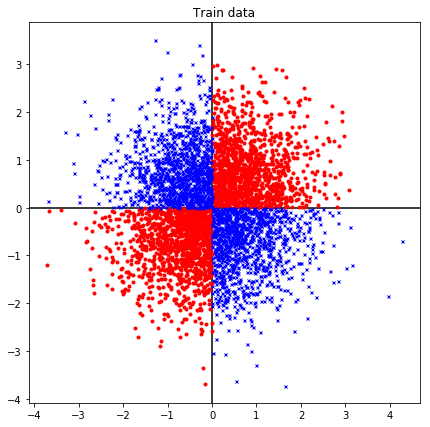

In [70]:
true_list = []
false_list = []
label_list = []
for data, label in train_data:
    if label == 1:
        true_list.append(data.numpy())
    else:
        false_list.append(data.numpy())
true_x = np.array(true_list).squeeze()[:, 0]
true_y = np.array(true_list).squeeze()[:, 1]
false_x = np.array(false_list).squeeze()[:, 0]
false_y = np.array(false_list).squeeze()[:, 1]

plt.figure(figsize=(7, 7))
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title('Train data')

plt.plot(true_x, true_y, 's', markersize=3, marker='o', color='r')
plt.plot(false_x, false_y, 's', markersize=3, marker='x', color='b')

## Single layer neural network
* Single layer neural network
    * Fully connected layer - in_features: 2, out_features: 1
    * Apply Sigmoid activation function for the output layer.

In [71]:
# TODO
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.fc1(x))
        #return F.sigmoid(self.fc1(x))

### Train the network on the training data

#### Define a Loss function and optimizer
* Use Bineary Cross-Entropy loss
* Use SGD with learning rate 0.01 and momentum 0.5

In [72]:
# define a loss and optimizer
# TODO
loss_obj = nn.BCELoss()

def create_optimizer(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    return optimizer

#### Define training loop

In [73]:
# TODO
def train(model, num_epochs, loss_obj):
    model.train() # nn.module에 숨겨져 있는 함수, train할 때 global moving average를 업데이트 하도록 동작 (Dropout, BatchNorm등에서 적용)
    optimizer = create_optimizer(model)
    for epoch in range(num_epochs):
        for batch_idx, (input, target) in enumerate(train_loader):
            # move tensors to device
            input, target = input.to(torch.device('cuda')), target.to(torch.device('cuda'))

            optimizer.zero_grad()
            output = model(input)
            loss = loss_obj(output, target.float())
            loss.backward()
            optimizer.step()

            print('\r[Epoch {}/{}][itr {}/{}] Loss: {}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss), end='')

In [74]:
# train the network
# epoch = 10
# TODO
model_single_ann = ANN().to(device)
train(model_single_ann, 10, loss_obj)

[Epoch 10/10][itr 157/157] Loss: 0.6940849423408508

### Define test loop

In [75]:
def test(model, loss_obj):
    predict_true = []
    predict_false = []

    model.eval() # test를 할때 global moving average를 업데이트 하지 않고 가져다 쓰도록 동작(Dropout, BatchNorm등에서 적용)
    test_loss = 0
    correct = 0
    for input, target in test_loader:
        input, target = input.to(device), target.to(device)

        with torch.no_grad(): # gradient 업데이트 안할테니깐 버퍼를 저장하지 않도록 하는 함수
            output = model(input)

        test_loss += loss_obj(output, target.float()).data # sum up batch loss
        pred = torch.round(output).data # get the index of the max log-probability
        correct += pred.eq(target.data.float().view_as(pred)).cpu().sum()
        if pred.sum() == 0:
            predict_false.append(input.data.tolist())
        else:
            predict_true.append(input.data.tolist())

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return predict_true, predict_false

### Test the network on the test data


Test set: Average loss: 0.6935, Accuracy: 427/1000 (43%)



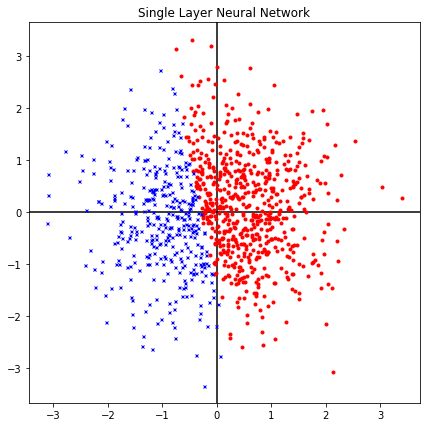

In [76]:
# test the network
# TODO
predict_true, predict_false = test(model_single_ann, loss_obj)

# visualize
def visualize_output(predict_true, predict_false, title=''):
    predict_true_x = np.array(predict_true).squeeze()[:, 0]
    predict_true_y = np.array(predict_true).squeeze()[:, 1]
    predict_false_x = np.array(predict_false).squeeze()[:, 0]
    predict_false_y = np.array(predict_false).squeeze()[:, 1]

    plt.figure(figsize=(7, 7))

    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    plt.title(title)

    plt.plot(predict_true_x, predict_true_y, 's', markersize=3, marker='o', color='r')
    plt.plot(predict_false_x, predict_false_y, 's', markersize=3, marker='x', color='b')

# TODO
visualize_output(predict_true, predict_false, 'Single Layer Neural Network')

## Linear DNN
* Linear DNN
    * Fully connected layer - in_features: 2, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 1
    * Apply no activation function for hidden layers.
    * Apply Sigmoid activation function for the output layer.

In [79]:
# TODO
class LinearDNN(nn.Module):
    def __init__(self):
        super(LinearDNN, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

### Train the network on the training data

In [82]:
#TODO
model_linear_dnn = LinearDNN().to(device)
train(model_linear_dnn, 20, loss_obj)

[Epoch 20/20][itr 157/157] Loss: 0.7124080657958984

### Test the network on the test data


Test set: Average loss: 0.6932, Accuracy: 463/1000 (46%)



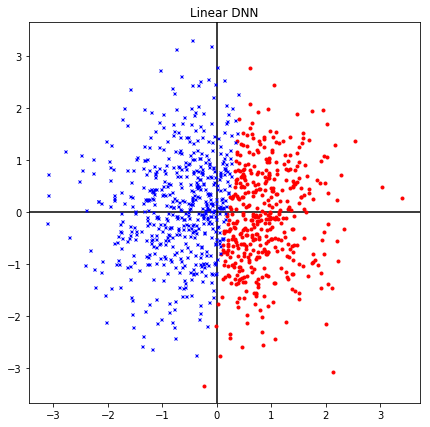

In [83]:
#TODO
predict_true, predict_false = test(model_linear_dnn, loss_obj)

visualize_output(predict_true, predict_false, 'Linear DNN')

## DNN
* DNN
    * Fully connected layer - in_features: 2, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 20
    * Fully connected layer - in_features: 20, out_features: 1
    * Apply ReLU activation function for hidden layers.
    * Apply Sigmoid activation function for the output layer.

In [87]:
# TODO
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

### Train the network on the training data

In [88]:
#TODO
model_dnn = DNN().to(device)
train(model_dnn, 10, loss_obj)

[Epoch 10/10][itr 157/157] Loss: 0.11009607464075089

### Test the network on the test data


Test set: Average loss: 0.1339, Accuracy: 987/1000 (99%)



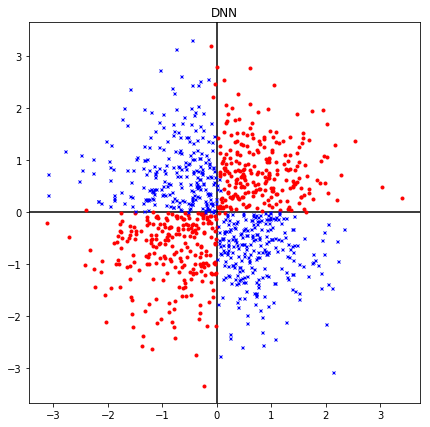

In [89]:
#TODO
predict_true, predict_false = test(model_dnn, loss_obj)

visualize_output(predict_true, predict_false, 'DNN')

In [ ]:
'''
* 국룰 parameter 정리
1. Adam(1e-4)
2. Relu -> Leaky relu(0.1~0.2) -> prelu
3. ADAMW

* 판도를 바꾼 논문들(부흥을 이끌어주는 방법들)
1. BatchNorm -> Vanishing Gradient
2. ReLU      -> BatchNorm 없어도 되고 무겁지도 않고
3. ResNet    -> ReLU를 써도 Gradient가 약해질 수 있는데 Gradient가 Vanishing되지 않도록해서 학습이 잘된다.(카이밍 허(K He))

Transfomer(K He) 요즘 뜨고 있다
'''